In [2]:
from llama_cpp import Llama
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import torch
from torch.nn import functional as F

In [3]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/WizardLM-13B-Uncensored-Q5_1-GGML/WizardML-Unc-13b-Q5_1.bin"

LLM = Llama(model_path=model_bin, n_ctx=2048, n_threads=7, use_mmap=False, n_batch=512)

llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/WizardLM-13B-Uncensored-Q5_1-GGML/WizardML-Unc-13b-Q5_1.bin
llama_model_load_internal: format     = ggjt v1 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 5120
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 40
llama_model_load_internal: n_layer    = 40
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 9 (mostly Q5_1)
llama_model_load_internal: n_ff       = 13824
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 13B
llama_model_load_internal: ggml ctx size = 9534512.58 KB
llama_model_load_internal: mem required  = 11359.05 MB (+ 1608.00 MB per state)
...


Initializing CLBlast (First Run)...
Attempting to use: Platform=0, Device=0 (If invalid, program will crash)
Using Platform: NVIDIA CUDA Device: NVIDIA GeForce RTX 3060 Ti


.................................................................................................
llama_init_from_file: kv self size  = 1600.00 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [4]:
def get_logits_and_probs(prompt):
    tokens = LLM.tokenize(prompt.encode('utf-8'))
    LLM.reset()
    LLM.eval(tokens)
    logits = LLM.eval_logits
    logits = np.array(logits[0])
    probs=F.softmax(torch.from_numpy(logits)).numpy()
    return logits, probs

In [5]:
def plot_logits(logits, bins=50):
    counts, bins = np.histogram(logits, bins=bins)
    plt.stairs(counts, bins)
    plt.title('Histogram of logits')

In [6]:
def plot_probs(probs, bins=1000, bins_to_skip=2):
    counts, bins = np.histogram(probs, bins=bins)
    # Observing that the vast majority of tokens are in the first bin, i.e. have incredibly small probability.
    print('There are {} tokens outside the {} smallest bins.'.format(len(np.where(probs>bins[bins_to_skip])[0]), bins_to_skip))
    # Don't plot the smallest bins since they are not interesting and dwarf all other bins
    plt.stairs(counts[bins_to_skip:], bins[bins_to_skip:])
    plt.title('Histogram of Token Probabilities')

In [7]:
def plot_most_likely_tokens(probs, num_tokens_to_plot=10):
    ind = np.argpartition(probs, -num_tokens_to_plot)[-num_tokens_to_plot:]

    likely_tokens = []
    token_probs = []

    for token in ind:
        c_token = [(ctypes.c_int)(*[token])]
        print('Token: {}, Prob: {}'.format(LLM.detokenize(c_token), probs[token]))
        # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
        likely_tokens.append(LLM.detokenize(c_token))
        token_probs.append(probs[token])

    plt.bar(likely_tokens, token_probs)
    plt.title('Bar chart of 10 most likely tokens')

I am going to give you a command, and you are going to classify it. The possible classifications are Heading, Speed, and Unknown. Respond "Classification: X" where X is the most likely classification. The input command is "Set the jelly, John!"

### Response:Classification:


/tmp/ipykernel_2236693/2195467913.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


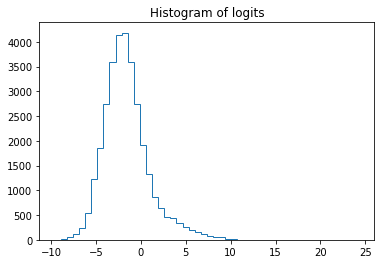

There are 4 tokens outside the 2 smallest bins.


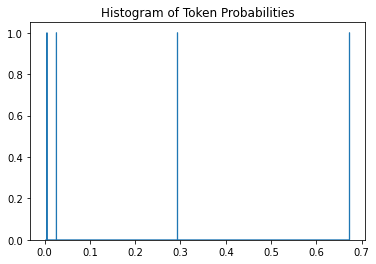

Token: b' Setting', Prob: 1.4688126494310248e-05
Token: b' speed', Prob: 3.393249551872772e-05
Token: b' He', Prob: 0.025935533296714698
Token: b'speed', Prob: 3.4303614731546964e-05
Token: b' Un', Prob: 0.6737261672024591
Token: b' Head', Prob: 0.001249458552090516
Token: b' J', Prob: 5.044849261474508e-05
Token: b' Speed', Prob: 0.29343119301922055
Token: b' Spe', Prob: 0.005265496365311606
Token: b'Speed', Prob: 0.0001790052604874737


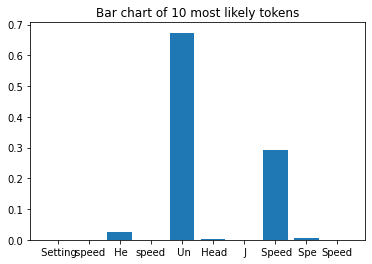

In [14]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "Bring us to full stop, John."
#command = "Full stop, John"
#command = "I love jelly!"
#command = "John, I love jelly!"
command = "Set the jelly, John!"
#command = "Jelly set bongus heading."

prompt = """I am going to give you a command, and you are going to classify it. The possible classifications are Heading, Speed, and Unknown. Respond "Classification: X" where X is the most likely classification. The input command is "{}"

### Response:Classification:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

I am going to give you a statement, and you are going to classify it. The possible classifications are Remark, Question, and Command. Respond "Classification: X" where X is the most likely classification. The input statement is "John, I love jelly!"

### Response:Classification:


/tmp/ipykernel_2236693/2195467913.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


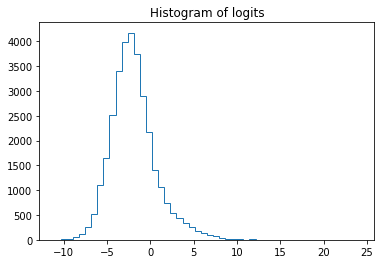

There are 4 tokens outside the 2 smallest bins.


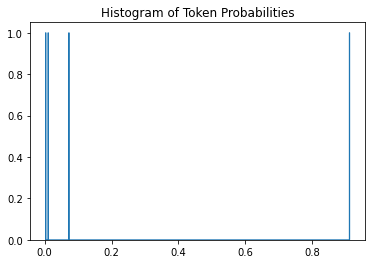

Token: b'Rem', Prob: 1.3198496099088237e-05
Token: b' Jo', Prob: 1.4427416153334316e-05
Token: b' statement', Prob: 2.576627132145427e-05
Token: b' J', Prob: 7.08525540643058e-05
Token: b' Stat', Prob: 0.010602868546922483
Token: b' Rem', Prob: 0.9128632461498466
Token: b' Comment', Prob: 3.827807984198497e-05
Token: b' Question', Prob: 0.07261683977567723
Token: b' X', Prob: 0.0007305604355389976
Token: b' Command', Prob: 0.0029078996175439073


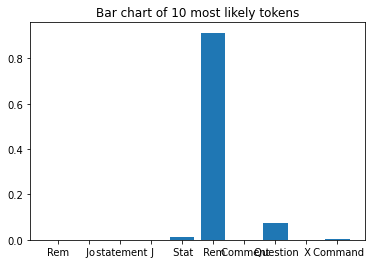

In [9]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "We've got our hands full today."
#command = "Bring us to full stop, John."
#command = "Full stop, John."
#command = "I love jelly!"
command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
#command = "Warp 3. Engage."
#command = "What's our current heading?"

prompt = """I am going to give you a statement, and you are going to classify it. The possible classifications are Remark, Question, and Command. Respond "Classification: X" where X is the most likely classification. The input statement is "{}"

### Response:Classification:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()